# Implementacion algoritmo predicción SOH
Se busca implementar el algorito de Machine Learning de Procesos Gaussianos

### Funciones para análisis de los EIS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Funciones para extraer resistencias (R) y reactancias (X).
def cycle_resistances(dataFrame):
    # Input: Txt de la base de datos de EIS Cambridge como DataFrame
    # Output: Lista con 350 listas. Cada una son los valores de resistencia
    #         de un mismo ciclo

    resistance_arrays = []
    Ns = int(dataFrame.shape[0]/60)
    for i in range(1,Ns+1):
        df1 = dataFrame[dataFrame["cycle number"]==i].copy(deep=True)
        reZ = df1["Re(Z)/Ohm"].to_list()
        resistance_arrays.append(reZ)
    return resistance_arrays

def cycle_reactances(dataFrame):
    # Input: Txt de la base de datos de EIS Cambridge como DataFrame
    # Output: Lista con 350 listas. Cada una son los valores de reactancia
    #         de un mismo ciclo
    reactance_arrays = []
    Ns = int(dataFrame.shape[0]/60)
    for i in range(1,Ns+1):
        df1 = dataFrame[dataFrame["cycle number"]==i].copy(deep=True)
        imZ = df1["-Im(Z)/Ohm"].to_list()
        reactance_arrays.append(imZ)
    return reactance_arrays

# Calculo derivada de array
def derivada_imZ(r,x):
    d = [0] 
    for i in range(len(x)-1):
        m1 = (x[i+1]-x[i])/(r[i+1]-r[i])    # dx/dr en i+1
        d.append(m1)
    return d

# Calculo segunda derivada de array
def derivada2_imZ(r,x):
    d2 = [0,0]
    for i in range(len(x)-2):
        m1 = (x[i+1]-x[i])/(r[i+1]-r[i])    # dx/dr en i+1
        m2 = (x[i+2]-x[i+1])/(r[i+2]-r[i+1])    # dx/dr en i+2
        mm2 = (m2-m1)/(r[i+2]-r[i+1])    # d2x/dr2 en i+2
        d2.append(mm2)
    return d2

#  Promedio hacia adelante
def avgs_d1(d1x):
    d1s_avg = [0,0]                 # lista que guarda los promedios
    for i in range(len(d1x)-3-2):   # calcula solo hasta 5 muestras antes del fin: no indexar mal
        avg = (d1x[i+2] + d1x[i+3] + d1x[i+4] + d1x[i+5])*0.25  # promedio 4 muestras
        d1s_avg.append(avg)
    return d1s_avg

# Algoritmo de buscar indice que ajusta mejor
def search_curve(r,x):
    # r: lista Resistencias Nyquist
    # x: lista Reactancias Nyquist
    # output: indice  
    c1 = 0                  # condicion 1
    c2 = 0                  # condicion 2
    j = 25                  # default: cortat a los 57.4 Hz
    d1 = derivada_imZ(r,x)  # Primeras derivadas
    d2 = derivada2_imZ(r,x) # Segundas derivadas
    mean4_d1 = avgs_d1(d1)  # Promedios 4 samples d1
    mean4_d2 = avgs_d1(d2)  # Promedios 4 samples d2
    # A buscar el indice
    # 1.- Buscar el indice en que el avg d1 es menor a 0.45 -> linea diagonal
    for i in range(2,30):
        if (mean4_d1[i] < 0.45):
            j = i
            c1 = 1
            break
    # 2.- A partir del indice anterior, buscar cuando avg d2 es mayor a 0 -> curva hacia arriba
    if (c1 == 1):
        for i in range(j,30):
            if (mean4_d2[i] > 0):
                j = i
                c2 = 1
                break
    return j


# Guardar maxima capacidad de cada ciclo - Archivo Data_Capacity
def cycle_MaxCapacity(capacityDF):
    # Calcular la última muestra de cada ciclo del archivo "Data_Capacity_x5C0n"
    max_cap = []                                     # Guardar la máxima capacidad por ciclo
    for i in range(1,capacityDF.shape[0]):           # Recorrer el DF desde la segunda fila
        if ((capacityDF.iloc[i,1] - capacityDF.iloc[i-1,1]) > 0):     # Comparar ciclo de i con ciclo de i-1
            max_cap.append(capacityDF["Capacity/mA.h"].iloc[i-1])   # Agregar a la lista
    return max_cap 

### Función para obtener coordenadas y radio de circunferencia
A partir de un diagrama de Nyquist.

In [40]:
from pyomo.environ import ConcreteModel, Var, Objective, SolverFactory, minimize, NonNegativeReals, Param, RangeSet
import numpy as np


def geo_Nyquist(nyquistSamples):
    # Input: nyquistSamples lista de 2 columnas
    # Columna 0: resistencias
    # Columna 1: reactancias

    # Crear el modelo
    model = ConcreteModel()

    # Variables de decisión: coeficientes de la circunferencia
    model.p1 = Var()    # theta 1
    model.p2 = Var()    # theta 2
    model.p3 = Var()    # theta 3

    # Conjunto de puntos
    N = len(nyquistSamples)
    model.i = RangeSet(N)

    # Parámetros: coordenadas de los puntos
    model.r = Param(model.i, initialize=lambda model, i: nyquistSamples[i-1, 0])    # i e [1, 2, 3, ..., N]
    model.x = Param(model.i, initialize=lambda model, i: nyquistSamples[i-1, 1])    # indexacion como en Matlab/Julia

    # Función objetivo: Minimizar la suma de los cuadrados de las diferencias (residuos)
    def objective_rule(model):
        return sum((model.r[i]**2 + model.x[i]**2 + model.p1*model.r[i] + model.p2*model.x[i] + model.p3)**2 for i in model.i)

    model.obj = Objective(rule=objective_rule, sense=minimize)  # incluir FO en modelo - minimizar

    # Resolver el problema
    solver = SolverFactory('gurobi')  # Puedes usar cualquier solver compatible, por ejemplo 'glpk'
    solver.solve(model, tee=True)

    # Calcular el centro y el radio de la circunferencia
    cx = -model.p1() / 2
    cy = -model.p2() / 2
    r = np.sqrt(model.p1()**2 + model.p2()**2 - 4*model.p3()) / 2

    parametros = {"cx":cx, "cy":cy, "r":r}
    return parametros



### Lectura de archivos CSV como DataFrames

In [3]:
# Leer datos
eis_c1 = pd.read_csv("EIS_state_V_25C01.csv",sep=',', header=0, index_col=False)
eis_c2 = pd.read_csv("EIS_state_V_25C02.csv",sep=',', header=0, index_col=False)
eis_c3 = pd.read_csv("EIS_state_V_25C03.csv",sep=',', header=0, index_col=False)
eis_c4 = pd.read_csv("EIS_state_V_25C04.csv",sep=',', header=0, index_col=False)
eis_c5 = pd.read_csv("EIS_state_V_25C05.csv",sep=',', header=0, index_col=False)
eis_c6 = pd.read_csv("EIS_state_V_25C06.csv",sep=',', header=0, index_col=False)
eis_c7 = pd.read_csv("EIS_state_V_25C07.csv",sep=',', header=0, index_col=False)
eis_c8 = pd.read_csv("EIS_state_V_25C08.csv",sep=',', header=0, index_col=False)
#eis_soc9 = pd.read_csv("EIS_state_IX_25C05.csv",sep=',', header=0, index_col=False)

# Resistencias y reactancias para Nyquist
# SOC 1
r_c1 = cycle_resistances(eis_c1)
x_c1 = cycle_reactances(eis_c1)
# SOC 2
r_c2 = cycle_resistances(eis_c2)
x_c2 = cycle_reactances(eis_c2)
# SOC 3
r_c3 = cycle_resistances(eis_c3)
x_c3 = cycle_reactances(eis_c3)
# SOC 4
r_c4 = cycle_resistances(eis_c4)
x_c4 = cycle_reactances(eis_c4)
# SOC 5
r_c5 = cycle_resistances(eis_c5)
x_c5 = cycle_reactances(eis_c5)
# SOC 6
r_c6 = cycle_resistances(eis_c6)
x_c6 = cycle_reactances(eis_c6)
# SOC 7
r_soc7 = cycle_resistances(eis_c7)
x_soc7 = cycle_reactances(eis_c7)
# SOC 8
#r_soc8 = cycle_resistances(eis_soc8)
#x_soc8 = cycle_reactances(eis_soc8)
# SOC 9
#r_soc9 = cycle_resistances(eis_soc9)
#x_soc9 = cycle_reactances(eis_soc9)

# r_soci = [Nyquist_ciclo1, Nyquist_ciclo2, ..., Nyquist_cicloN]
# x_soci = [Nyquist_ciclo1, Nyquist_ciclo2, ..., Nyquist_cicloN]
# N: el número de ciclos de la batería C04 a 25°C en el estado i.

### Cortar las primeras 13 muestras de un diagrama de Nyquist

In [4]:
def nyquist_cut(cycle, cycleRs, cycleXs):
    # Rescata las primeras 13 muestras: hasta 1200 Hz
    cut = 13    # indice donde corta (0-12)

    points = np.zeros(shape=(cut,2))    # Matrix para guardar samples
    for i in range(cut):
        points[i,0] = cycleRs[cycle][i] # agregar resistencia del ciclo y de la frecuencia
        points[i,1] = cycleXs[cycle][i] # agregar reactancia del ciclo y de la frecuencia

    return points 

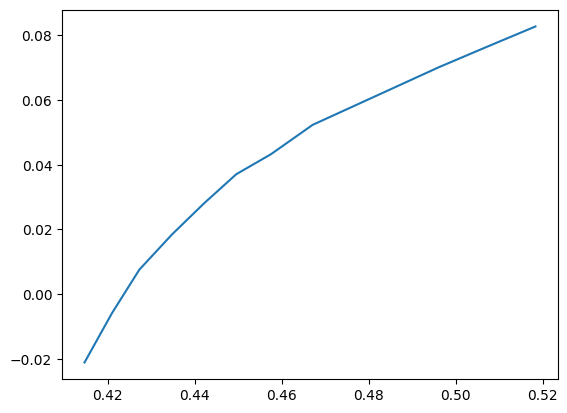

In [5]:
prueba = nyquist_cut(50, r_c5, x_c5)
plt.plot(prueba[:,0],prueba[:,1])

In [6]:
diccionario = geo_Nyquist(prueba)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-26
Read LP format model from file C:\Users\sevil\AppData\Local\Temp\tmp36ga11zx.pyomo.lp
Reading time = 0.02 seconds
x1: 1 rows, 4 columns, 1 nonzeros
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1185G7 @ 3.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 4 columns and 1 nonzeros
Model fingerprint: 0x5940444c
Model has 6 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-01, 6e+00]
  QObjective range [6e-02, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 1 rows and 1 columns
Presolve time: 0.00s
Presolved: 0 rows, 3 columns, 0 nonzeros
Presolved model has 6 quadratic objective terms
Ordering time: 0.00s

Barrier statisti

### Sacar la capacidad real de la bateria
Problema: hay muchas mediciones para un mismo ciclo.
Solucion: se calcula la capacidad máxima por ciclo. Luego el estado 5 corresponde a la carga al 100%.

In [7]:
cap_c5 = pd.read_csv("Data_Capacity_25C05.csv",sep=',', header=0, index_col=False)
cap_c5

,time/s,cycle number,ox/red,Capacity/mA.h
0,0.000000e+00,0.0,1,0.000000
1,2.000000e-04,0.0,1,0.000003
2,4.000000e-04,0.0,1,0.000005
3,8.000000e-04,0.0,1,0.000010
4,1.200000e-03,0.0,1,0.000015
...,...,...,...,...
627650,4.228293e+06,328.0,1,2.690540
627651,4.228303e+06,328.0,1,2.715155
627652,4.228306e+06,328.0,1,2.721403
627653,4.229806e+06,328.0,1,2.721403


### Gráficos

<Axes: title={'center': 'Estado de carga - ciclo 10'}, xlabel='Número medición', ylabel='Carga mAh'>

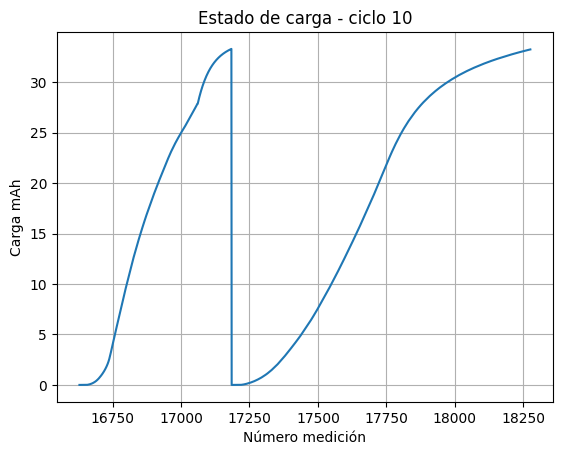

In [8]:
cap_c5[cap_c5["cycle number"]==10]["Capacity/mA.h"].plot(grid=True, xlabel="Número medición", ylabel="Carga mAh", title="Estado de carga - ciclo 10")

<Axes: title={'center': 'Estado de carga - ciclo 0-6'}, xlabel='tiempo [s]', ylabel='Carga mAh'>

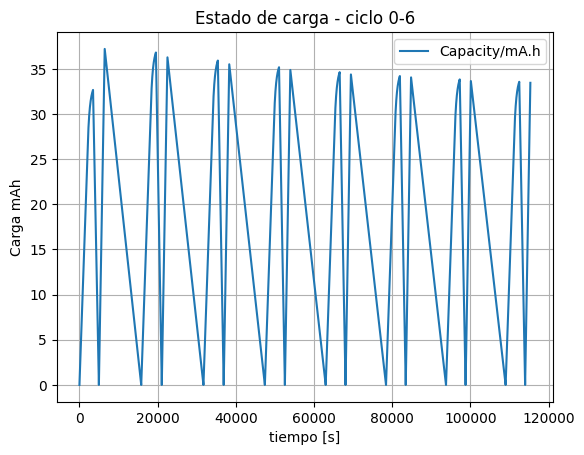

In [9]:
cap_c5[cap_c5["cycle number"]<=7].plot(x="time/s", y= "Capacity/mA.h",grid=True, xlabel="tiempo [s]", ylabel="Carga mAh", title="Estado de carga - ciclo 0-6")

### Mejorar este algoritmo para sacar las CAPACIDADES

In [10]:
# OJO CON ESTE ALGORITMO
max_cap = []                        # Guardar la máxima capacidad por ciclo
max  = cap_c5.iloc[0,3]             # Condicion inicial maximo
for i in range(1, cap_c5.shape[0]):    # Recorrer desde la segunda hasta el final de mediciones de capacidad de bateria
    cap = cap_c5.iloc[i,3]      # capacidad de la medicion i
    if cap > max:
        max = cap
    if ((cap_c5.iloc[i,1] - cap_c5.iloc[i-1,1]) > 0):     # Comparar ciclo de i con ciclo de i-1
        max_cap.append(max)


Algoritmo menos complejo: quedarse con el último valor de cada ciclo de medición

In [11]:
max_cap = []                        # Guardar la máxima capacidad por ciclo
max  = cap_c5.iloc[0,3]             # Condicion inicial maximo
for i in range(cap_c5.shape[0]):    # Recorrer el DF
    if ((cap_c5.iloc[i,1] - cap_c5.iloc[i-1,1]) > 0):     # Comparar ciclo de i con ciclo de i-1
        max_cap.append(cap_c5.iloc[i-1,3])
        

In [12]:
len(max_cap)

328

In [13]:
len(cycle_MaxCapacity(cap_c5))

328

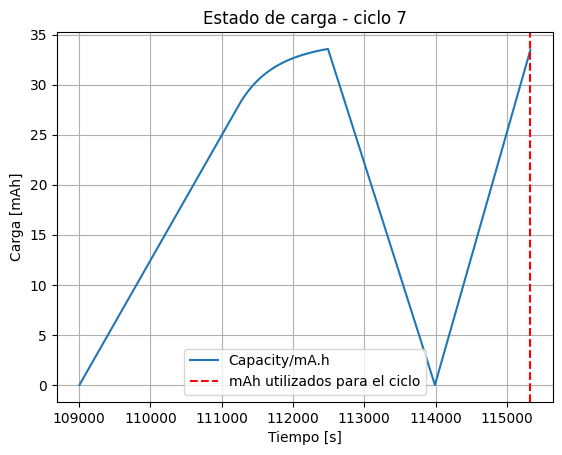

In [14]:
## Cortesía de OpenIA

import matplotlib.pyplot as plt
# Filtrar los datos para el ciclo número 7
data_cycle_7 = cap_c5[cap_c5["cycle number"] == 7]
# Obtener la última muestra de tiempo
last_time_sample = data_cycle_7["time/s"].iloc[-1]
# Crear la gráfica
fig, ax = plt.subplots()
data_cycle_7.plot(x="time/s", y="Capacity/mA.h", ax=ax, grid=True)
# Añadir la línea vertical en la última muestra
ax.axvline(x=last_time_sample, color='red', linestyle='--', label='mAh utilizados para el ciclo')
# Añadir etiquetas y título
ax.set_xlabel("Tiempo [s]")
ax.set_ylabel("Carga [mAh]")
ax.set_title("Estado de carga - ciclo 7")
# Añadir la leyenda
ax.legend()
# Mostr la gráfica
plt.show()



In [41]:
## CREAR ARRAY CON PARÁMETROS XYR A PARTIR DE UN ARCHIVO EIS

def parametros_XYR(EIS_DF):
    # Calcular resistencias y reactancias de cada ciclo
    r_ciclo = cycle_resistances(EIS_DF)
    x_ciclo = cycle_reactances(EIS_DF)

    # Numero de ciclos de carga del archivo del EIS
    Nciclos = len(r_ciclo)

    # Array que guarda XYR - Nciclos filas y 3 columnas
    array_XYR = np.zeros((Nciclos,3))                       

    
    for i in range(Nciclos):
        # Tomar XYR del Nyquist de cada ciclo
        samples_nyquist = nyquist_cut(i, r_ciclo, x_ciclo)  # tomar las 13 primeras muestras del Nyquist del ciclo i
        parametros = geo_Nyquist(samples_nyquist)           # ajustar circunferencia: calcular X, Y y R : diccionario 3 claves
        # Guardar cada caracteristica en la fila i del array
        array_XYR[i,0] = parametros["cx"]
        array_XYR[i,1] = parametros["cy"]
        array_XYR[i,2] = parametros["r"]
    
    return array_XYR

### Crear matrix para entrenar datos (State V - C05)

In [15]:
entradas_geo = np.zeros((len(r_c5),3))

for i in range(len(r_c5)):        # recorrer todos los nyquist (ciclos)
    # Tomar muestras del diagrama de nyquist y ajustar circunferencia
    samples_nyquist = nyquist_cut(i, r_c5, x_c5)            # tomar las 13 primeras muestras del diagrama
    parametros = geo_Nyquist(samples_nyquist)     # ajustar circunferencia: sacar coordenadas y el radio

    # Agregar parametros geometricos a la fila i
    entradas_geo[i,0] = parametros["cx"]
    entradas_geo[i,1] = parametros["cy"]
    entradas_geo[i,2] = parametros["r"]


Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-26
Read LP format model from file C:\Users\sevil\AppData\Local\Temp\tmpvo5omfzf.pyomo.lp
Reading time = 0.02 seconds
x1: 1 rows, 4 columns, 1 nonzeros
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1185G7 @ 3.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 4 columns and 1 nonzeros
Model fingerprint: 0x2e9e28cd
Model has 6 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-01, 4e+00]
  QObjective range [6e-02, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 1 rows and 1 columns
Presolve time: 0.00s
Presolved: 0 rows, 3 columns, 0 nonzeros
Presolved model has 6 quadratic objective terms
Ordering time: 0.00s

Barrier statisti

Outputs en array

In [16]:
salidas_cap = np.zeros((len(r_c5),1))
for i in range(len(r_c5)):
    salidas_cap[i,0] = max_cap[i]

### Observar las circunferencias
Gentileza de OpenAI.
- Nyquist de estado 5 (carga completa).
- Estado de carga medido justo antes de comenzar un nuevo ciclo.
- Batería C05 a 25°C constantes.

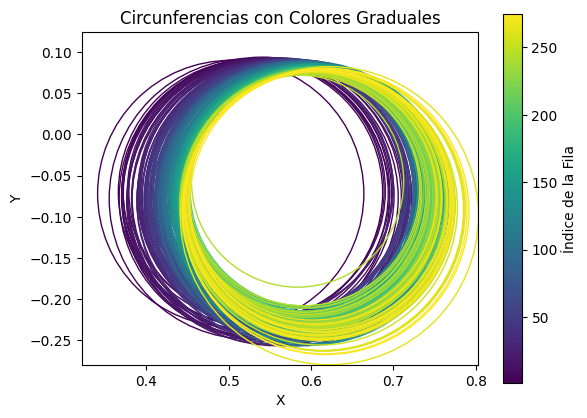

In [17]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar

# Supongamos que tu matriz se llama 'data' y es de tamaño 275x3
# data = np.array([[x1, y1, r1], [x2, y2, r2], ..., [x275, y275, r275]])
# Como ejemplo, voy a generar una matriz aleatoria
np.random.seed(0)
data = entradas_geo

# Crear una figura y un eje
fig, ax = plt.subplots()

# Usar un colormap para asignar colores
colormap = cm.viridis
num_circles = data.shape[0]
colors = colormap(np.linspace(0, 1, num_circles))

# Graficar cada circunferencia con un color diferente
for i in range(num_circles):
    x, y, r = data[i]
    color = colors[i]
    circ = plt.Circle((x, y), r, edgecolor=color, facecolor='none')
    ax.add_patch(circ)

# Ajustar los límites del gráfico
ax.set_xlim(data[:,0].min() - data[:,2].max(), data[:,0].max() + data[:,2].max())
ax.set_ylim(data[:,1].min() - data[:,2].max(), data[:,1].max() + data[:,2].max())

# Configurar el aspecto del gráfico
ax.set_aspect('equal', 'box')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Circunferencias con Colores Graduales')

# Crear una barra de color
sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=1, vmax=num_circles))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Índice de la Fila')

# Mostrar el gráfico
plt.show()



### Capacidad respecto a parámetros
Cortesía de OpenAI

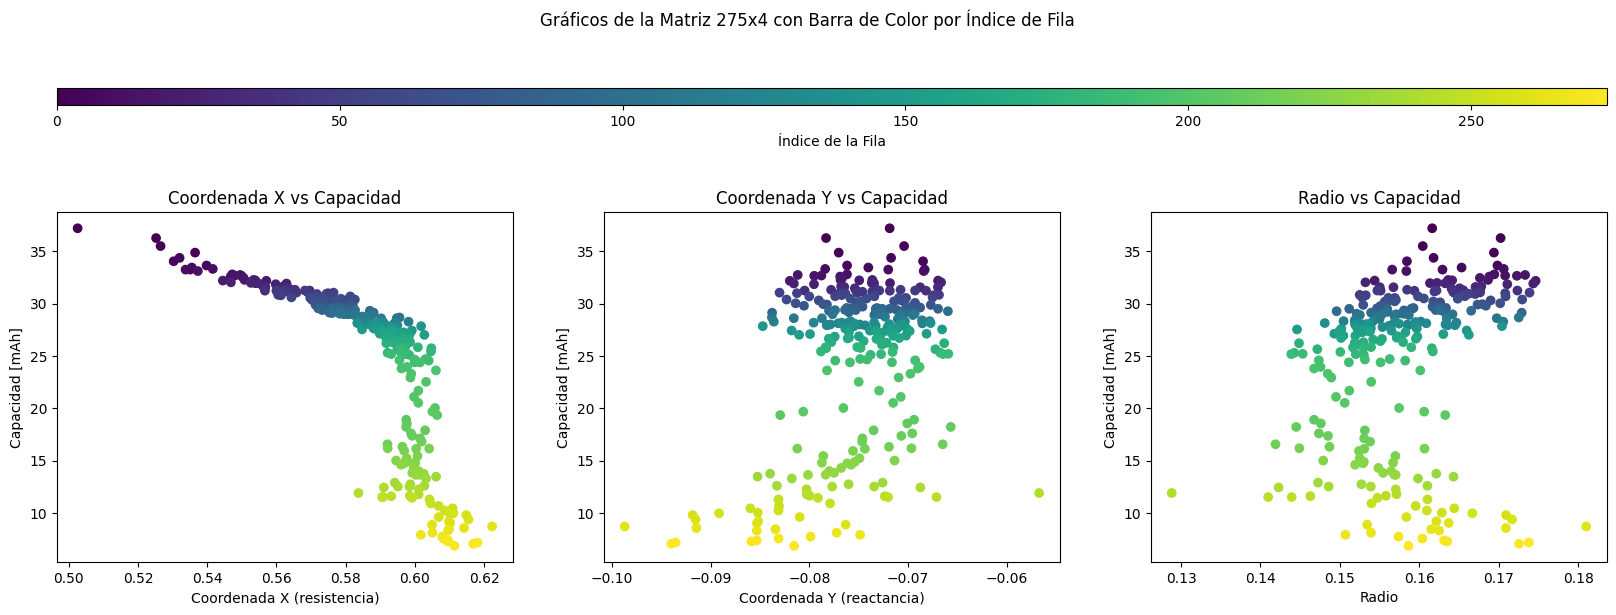

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm

# Supongamos que tu matriz se llama 'data' y es de tamaño 275x4
# data = np.array([[x1, y1, r1, v1], [x2, y2, r2, v2], ..., [x275, y275, r275, v275]])
np.random.seed(0)
data = entradas_geo
salida = salidas_cap

# Crear una figura con una cuadrícula de subparcelas (GridSpec)
fig = plt.figure(figsize=(20, 8))  # Aumentar el tamaño de la figura para acomodar la barra de color
gs = GridSpec(3, 3, height_ratios=[0.1, 0.05, 1], hspace=0.8)  # Crear una cuadrícula con espacio para la barra de color

# Títulos de los gráficos
titles = ['Coordenada X vs Capacidad', 'Coordenada Y vs Capacidad', 'Radio vs Capacidad']
etiquetasX = ["Coordenada X (resistencia)", "Coordenada Y (reactancia)", "Radio"]

# Usar un colormap para asignar colores
colormap = cm.viridis
num_rows = data.shape[0]
colors = colormap(np.linspace(0, 1, num_rows))

# Graficar los datos en cada subgráfico
for i in range(3):
    ax = fig.add_subplot(gs[2, i])
    sc = ax.scatter(data[:, i], salida[:, 0], c=np.arange(num_rows), cmap=colormap)
    ax.set_xlabel(etiquetasX[i])
    ax.set_ylabel('Capacidad [mAh]')
    ax.set_title(titles[i])

# Crear una barra de color compartida para los tres gráficos, ubicada en la segunda fila de la cuadrícula
cbar_ax = fig.add_subplot(gs[1, :])
cbar = fig.colorbar(sc, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Índice de la Fila')

# Configurar la figura
fig.suptitle('Gráficos de la Matriz 275x4 con Barra de Color por Índice de Fila', y=0.8)  # Ajustar la posición del título
plt.show()


## Regresion: SciLearn-Kit

- Entradas X: entradas_geo = [X, Y, R] - parámetros geométricos de la circunferencia ajustada desde Nyquist
- Salidas Y: salidas_cap = [mAh] - capacidad de carga de la batería

### Tomar data train-test
Se toman 225 muestras aleatorias

In [19]:
rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(entradas_geo.shape[0]), size=225, replace=False)    # 225/275 muestras    
X_train, y_train = entradas_geo[training_indices], salidas_cap[training_indices]

In [20]:
len(X_train)

225

In [21]:
X = entradas_geo
y = salidas_cap

### Kernel: RBF
La publicación estudiada utiliza este Kernel.

$ k(x_i,x_j) = $ $\Large { e^{-\frac{||x_i - x_j||^2}{2l^2}}}$

- Large lentgh-scale ($l$) -> más grande = más suave
- $l > 0$.


In [22]:
np.sqrt(y.var())

7.74755841158476

In [32]:
from sklearn.gaussian_process.kernels import RBF
kernel_soc = 7.74**2 * RBF()

La amplificación y valor inicial son hyperparámetros. Sin embargo, luego el modelo va ajustando el sigma y el l. Los valores inciales de este caso corresponden al ejemplo de la documentación: https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-co2-py

### Ajustar datos al modelo
Se ajusta el offset de los datos de salida en cero.

In [33]:
from sklearn.gaussian_process import GaussianProcessRegressor

y_mean = y.mean()
gaussian_process = GaussianProcessRegressor(kernel=kernel_soc, normalize_y=False)
gaussian_process.fit(X, y - y_mean)

GaussianProcessRegressor(kernel=7.74**2 * RBF(length_scale=1))

In [37]:
gaussian_process.predict(entradas_geo, return_std=True)

(array([ 12.51457016,  11.5802377 ,  10.81203862,  10.18735497,
          9.6877667 ,   9.36275017,   8.95779427,   8.76038511,
          8.5638281 ,   8.62941992,   8.56430349,   8.4253041 ,
          8.11132266,   7.9936161 ,   7.90257285,   8.05228555,
          7.97146211,   7.76930408,   7.5808221 ,   7.49103402,
          7.51398421,   7.57308025,   7.54203089,   7.27413306,
          7.23298535,   7.16732299,   7.34861841,   7.29487684,
          7.25795874,   6.97127102,   6.90711054,   6.87689357,
          6.88321622,   6.7792611 ,   6.74000758,   6.63517885,
          6.58962532,   6.56171407,   6.55088428,   6.54421274,
          6.47679279,   6.44451903,   6.36392347,   6.38459939,
          6.63953507,   6.56438648,   6.56396661,   6.22993857,
          6.14845005,   6.11023721,   6.36435962,   6.30869622,
          6.25845019,   6.02361591,   5.9091652 ,   5.8586735 ,
          6.12398916,   6.01134936,   6.00237007,   5.70469538,
          5.66518602,   5.62219809,   5.

## Prueba
Como datos de test se utiliza la totalidad de parámetros del State V de la batería C05

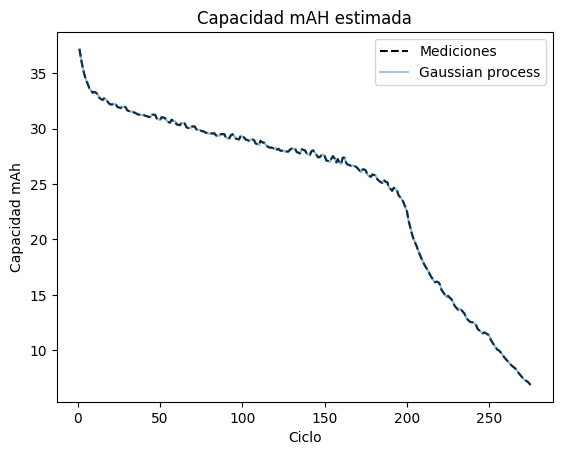

In [34]:
X_test = entradas_geo

mean_y_pred, std_y_pred = gaussian_process.predict(X_test, return_std=True)     # predecir media y desviacion estandar de los output
mean_y_pred += y_mean

indices = np.linspace(1, len(X),len(X))
plt.plot(indices, y, color="black", linestyle="dashed", label="Mediciones")
plt.plot(indices, mean_y_pred, color="tab:blue", alpha=0.4, label="Gaussian process")
plt.fill_between(
    indices.ravel(),
    mean_y_pred - 2*std_y_pred,
    mean_y_pred + 2*std_y_pred,
    color="tab:blue",
    alpha=0.2,
)
plt.legend()
plt.xlabel("Ciclo")
plt.ylabel("Capacidad mAh")
_ = plt.title(
    "Capacidad mAH estimada"
)

### Leer SOH de bateria 6

In [26]:
cap_c6 = pd.read_csv("Data_Capacity_25C06.csv",sep=',', header=0, index_col=False)
print(cap_c6.head())
print("-----------------------")
print("Filas:", cap_c6.shape[0])

   time/s  cycle number  ox/red   Voltaje  Corriente  Capacity/mA.h
0  0.0000           0.0       1  3.814915  44.992321       0.000000
1  0.0002           0.0       1  3.816921  44.994240       0.000002
2  0.0006           0.0       1  3.818327  44.994881       0.000007
3  0.0008           0.0       1  3.819492  44.996799       0.000010
4  0.0010           0.0       1  3.820543  45.003838       0.000012
-----------------------
Filas: 348370


## Parámetros X;Y;R y SOC para batería C06

In [27]:
X_c6 = np.zeros((len(r_c6),3))

for i in range(len(r_c6)):        # recorrer todos los nyquist (ciclos)
    # Tomar muestras del diagrama de nyquist y ajustar circunferencia
    samples_nyquist = nyquist_cut(i, r_c6, x_c6)            # tomar las 13 primeras muestras del diagrama
    parametros = geo_Nyquist(samples_nyquist)     # ajustar circunferencia: sacar coordenadas y el radio

    # Agregar parametros geometricos a la fila i
    X_c6[i,0] = parametros["cx"]
    X_c6[i,1] = parametros["cy"]
    X_c6[i,2] = parametros["r"]


Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-26
Read LP format model from file C:\Users\sevil\AppData\Local\Temp\tmpf577r4e4.pyomo.lp
Reading time = 0.02 seconds
x1: 1 rows, 4 columns, 1 nonzeros
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1185G7 @ 3.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 4 columns and 1 nonzeros
Model fingerprint: 0x9db3315c
Model has 6 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-01, 4e+00]
  QObjective range [2e-01, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 1 rows and 1 columns
Presolve time: 0.00s
Presolved: 0 rows, 3 columns, 0 nonzeros
Presolved model has 6 quadratic objective terms
Ordering time: 0.00s

Barrier statisti

In [50]:
def cap_battery(CapacityDF):
    # Guardar la capacidad maxima en mAH por ciclo
    cap_max_ciclo = cycle_MaxCapacity(CapacityDF)
    num_ciclos = len(cap_max_ciclo)
    # Array para guardar las capacidades   
    array_cap = np.zeros((num_ciclos,1))

    for i in range(num_ciclos):
        array_cap[i,0] = cap_max_ciclo[i]

    return array_cap

In [28]:
# Salidas de la bateria 6
Y_c6_lista = cycle_MaxCapacity(cap_c6)
Y_c6 = np.zeros((len(r_c6),1))
for i in range(len(r_c6)):
    Y_c6[i,0] = Y_c6_lista[i]


In [29]:
print("Entradas de datos entreno (C5):",len(X))
print("Entradas nuevos datos test (C6):",len(X_c6))
print("Salidas reales datos test (C6):",len(Y_c6))
print("-----------------------------------------")
print("A continuación se predicen las salidas de C6 (test) a partir del modelo entrenado con C5 (train)")
print("Estas predicciones se comparan con las mediciones reales.")

Entradas de datos entreno (C5): 275
Entradas nuevos datos test (C6): 212
Salidas reales datos test (C6): 212
-----------------------------------------
A continuación se predicen las salidas de C6 (test) a partir del modelo entrenado con C5 (train)
Estas predicciones se comparan con las mediciones reales.


### Prediccion y plot de los SOH de la batería 6
- Datos de entrada X: Nyquist_StateV_C06.
- Datos a predecir: SOH batería 6.
- Datos de salida Y: Mediciones del SOH de batería C06.

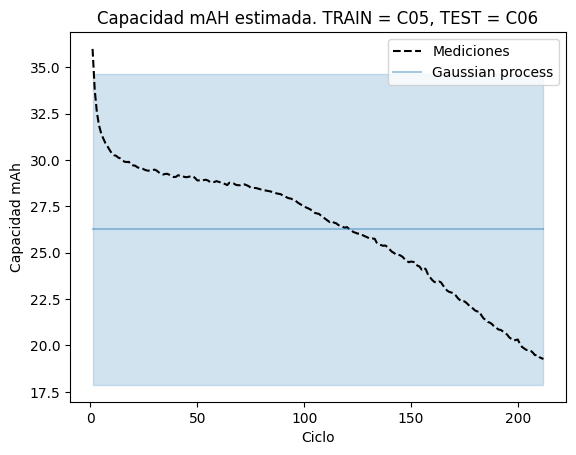

In [39]:
y_mean = Y_c6.mean()    # promedio C06
mean_y_pred, std_y_pred = gaussian_process.predict(X_c6, return_std=True)     # predecir media y desviacion estandar de los output
mean_y_pred += y_mean   # agregar el promedio a la prediccion centrada en cero

indices = np.linspace(1, len(X_c6),len(X_c6))     # indices para graficar: del 1 a la longitud de X
plt.plot(indices, Y_c6, color="black", linestyle="dashed", label="Mediciones")
plt.plot(indices, mean_y_pred, color="tab:blue", alpha=0.4, label="Gaussian process")
plt.fill_between(
    indices.ravel(),
    mean_y_pred - 1*std_y_pred,
    mean_y_pred + 1*std_y_pred,
    color="tab:blue",
    alpha=0.2,
)
plt.legend()
plt.xlabel("Ciclo")
plt.ylabel("Capacidad mAh")
_ = plt.title(
    "Capacidad mAH estimada. TRAIN = C05, TEST = C06"
)

# Por hacer:
- Entrenar con C01 a C04.
- Aprender a separar este entreno en grupos (C01, C02, C03 y C04).
- Chequear validación cruzada.
- Ajustar hiperparámetros del modelo hasta el menor error según validación cruzada.

In [38]:
gaussian_process.predict(X_c6, return_std=True)

(array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00

# Modelo con todos los datos de entreno

Para el modelo, al igual que en "Identifying degradation patterns of lithium ion batteries from impedance spectroscopy using machine learning", se utilizarán como datos de entreno las características de las baterías 1 a 4.

## X Train
Leer los parámetros de test (2 min 54 seg)

In [46]:
geo_c1 = parametros_XYR(eis_c1)
geo_c2 = parametros_XYR(eis_c2)
geo_c3 = parametros_XYR(eis_c3)
geo_c4 = parametros_XYR(eis_c4)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-26
Read LP format model from file C:\Users\sevil\AppData\Local\Temp\tmpf8e63f4n.pyomo.lp
Reading time = 0.01 seconds
x1: 1 rows, 4 columns, 1 nonzeros
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1185G7 @ 3.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 4 columns and 1 nonzeros
Model fingerprint: 0x4e0c0daa
Model has 6 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-01, 5e+00]
  QObjective range [7e-02, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 1 rows and 1 columns
Presolve time: 0.00s
Presolved: 0 rows, 3 columns, 0 nonzeros
Presolved model has 6 quadratic objective terms
Ordering time: 0.00s

Barrier statisti

In [70]:
print("Total de datos XYR 1:", len(geo_c1))
print("Total de datos XYR 2:", len(geo_c2))
print("Total de datos XYR 3:", len(geo_c3))
print("Total de datos XYR 4:", len(geo_c4))
print("Datos XYR totales:", len(geo_c1)+len(geo_c2)+len(geo_c3)+len(geo_c4))

Total de datos XYR 1: 261
Total de datos XYR 2: 250
Total de datos XYR 3: 229
Total de datos XYR 4: 81
Datos XYR totales: 821


## Y Train
Leer las capacidades correspondientes a cada ciclo de carga de cada bateria (44 seg)

In [61]:
capDF1 = pd.read_csv("Data_Capacity_25C01.csv",sep=',', header=0, index_col=False)
capDF2 = pd.read_csv("Data_Capacity_25C02.csv",sep=',', header=0, index_col=False)
capDF3 = pd.read_csv("Data_Capacity_25C03.csv",sep=',', header=0, index_col=False)
capDF4 = pd.read_csv("Data_Capacity_25C04.csv",sep=',', header=0, index_col=False)

cap_1 = cap_battery(capDF1)
cap_2 = cap_battery(capDF2)
cap_3 = cap_battery(capDF3)
cap_4 = cap_battery(capDF4)

In [69]:
print("Total de datos de salida C1:", len(cap_1))
print("Total de datos de salida C2:", len(cap_2))
print("Total de datos de salida C3:", len(cap_3))
print("Total de datos de salida C4:", len(cap_4))
print("Datos de salida totales:", len(cap_1)+len(cap_2)+len(cap_3)+len(cap_4))

Total de datos de salida C1: 349
Total de datos de salida C2: 180
Total de datos de salida C3: 201
Total de datos de salida C4: 34
Datos de salida totales: 764


## Grupos
- min(#geo_c1, #cap_1) = 261.
- min(#geo_c2, #cap_2) = 180.
- min(#geo_c3, #cap_3) = 201.
- min(#geo_c4, #cap_4) = 34.


In [89]:
grupos = np.zeros((261+180+201+34,1))
for i in range(676):
    if i <261:
        grupos[i,0] = 1
    elif i<261+180:
        grupos[i,0] = 2
    elif i<261+180+201:
        grupos[i,0] = 3
    elif i <261+180+201+34:
        grupos[i,0] = 4


201

## Cortar y Contatenar
Se corta cada array de forma que coincida con los numeros de ciclo de la capacidad de la batería que representan.
Además, se concatenan en un único gran vector.

In [96]:
X1 = geo_c1[0:261]
X2 = geo_c2[0:180]
X3 = geo_c3[0:201]
X4 = geo_c4[0:34]

Y1 = cap_1[0:261]
Y2 = cap_1[0:180]
Y3 = cap_1[0:201]
Y4 = cap_1[0:34]

X_train_SOH = np.concatenate([X1,X2,X3,X4])
Y_train_SOH = np.concatenate([Y1,Y2,Y3,Y4])


In [95]:
grupos

In [100]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold, cross_val_score

# Kernel RBF
kernel_SOH = ConstantKernel(1.0) * RBF(length_scale=1.0)

# Modelo GP
gp_SOH = GaussianProcessRegressor(kernel=kernel_SOH)

# Crear el objeto GroupKFold
group_kfold = GroupKFold(n_splits=4)

# Realizar la validación cruzada con el modelo y los datos agrupados
scores = cross_val_score(gp_SOH, X_train_SOH, Y_train_SOH, groups=grupos, cv=group_kfold)
                        #(modeloGP, X inputs, Y outputs  , grupos (baterias), Objeto Cross validation)

# NOTAR que con estas funciones no es necesario especificar datos de entreno y de test.
# La funcion va iterando la separacion para evaluar los parametros
# El modelo se validara con C5

print("Scores de validación cruzada:", scores)
print("Promedio de scores:", scores.mean())

######################################################

# Definir los parámetros para la búsqueda en cuadrícula
param_grid = {
    "kernel__k1__constant_value": [0.1, 1, 10],
    "kernel__k2__length_scale": [0.1, 1, 10]
}

# Crear el objeto GridSearchCV con GroupKFold
grid_search = GridSearchCV(gp_SOH, param_grid, cv=group_kfold, n_jobs=-1)
grid_search.fit(X_train_SOH, Y_train_SOH, groups=grupos)

# Mejores parámetros encontrados
best_params = grid_search.best_params_
print("Mejores parámetros:", best_params)

# Mejor modelo ajustado
best_model = grid_search.best_estimator_


Scores de validación cruzada: [  -18.73311777   -86.59046625  -135.2262289  -1337.58765652]
Promedio de scores: -394.53436735884065
Mejores parámetros: {'kernel__k1__constant_value': 10, 'kernel__k2__length_scale': 0.1}


## Validacion

Se comienza con el cálculo de parámetros geométricos XYR de la batería 5, así como sus capacidades en mAh medidas.

In [101]:
# XYR
geo_c5 = parametros_XYR(eis_c5)
# Capacidad
capDF5 = pd.read_csv("Data_Capacity_25C05.csv",sep=',', header=0, index_col=False)
cap_5 = cap_battery(capDF5)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-26
Read LP format model from file C:\Users\sevil\AppData\Local\Temp\tmpoj9rn134.pyomo.lp
Reading time = 0.01 seconds
x1: 1 rows, 4 columns, 1 nonzeros
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1185G7 @ 3.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 4 columns and 1 nonzeros
Model fingerprint: 0x2e9e28cd
Model has 6 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-01, 4e+00]
  QObjective range [6e-02, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 1 rows and 1 columns
Presolve time: 0.00s
Presolved: 0 rows, 3 columns, 0 nonzeros
Presolved model has 6 quadratic objective terms
Ordering time: 0.00s

Barrier statisti

Se imprime el largo de cada vector.

In [102]:
print("Datos XYR5:", len(geo_c5))
print("Datos cap5:", len(cap_5) )

Datos XYR5: 275
Datos cap5: 328


Cortar el vector de output para que coincida con XYR.

In [103]:
X_Test5 = geo_c5[0:275]
Y_Test5 = cap_5[0:275]